# II.A. Objective Function

In this notebook, we explore the map equation as an objective function and use it to compute the codelength of different partitions.

We also use Infomap to detect a network's community structure and compute the corresponding codelength

Because this notebook is intended as a learning resource, the code presented here is **not** optimised for speed.

In [1]:
%matplotlib inline

import infomap
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util import get_map_equation_example_network
from scipy.stats import entropy

In [2]:
# use pastel colours later
sns.set_palette(sns.color_palette("pastel"))

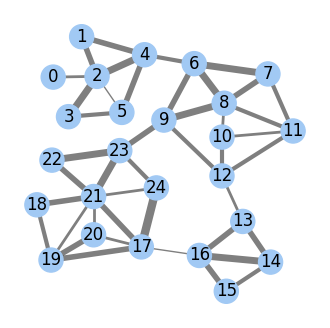

In [3]:
# we use the "standard" map equation example network and plot it below
# the networks is weighted and undirected
G, pos = get_map_equation_example_network()

fig, ax = plt.subplots(1, 1, figsize = (4, 4))

nx.draw_networkx_nodes(G = G, pos = pos, ax = ax, node_color = G.number_of_nodes() * [sns.color_palette()[0]])
nx.draw_networkx_edges(G = G, pos = pos, ax = ax, edgelist = sorted(G.edges), width = [G.get_edge_data(*e)["weight"] for e in sorted(G.edges)], alpha = 0.5)
nx.draw_networkx_labels(G = G, pos = pos, ax = ax)

ax.axis("off")
plt.show()

In undirected networks, we can calculate the node visit rate for node $u$ as $p_u = \frac{s_u}{\sum_v s_v}$, where $s_u$ is node $u$'s strength, that is, the total weight of its links.

In [4]:
# first, we save all nodes' strength in a dictionary
node_strengths = {u:G.degree(u, weight = "weight") for u in G.nodes()}
node_strengths

{0: 2,
 1: 8,
 2: 17,
 3: 8,
 4: 16,
 5: 8,
 6: 17,
 7: 12,
 8: 19,
 9: 16,
 10: 7,
 11: 11,
 12: 11,
 13: 10,
 14: 12,
 15: 7,
 16: 14,
 17: 17,
 18: 7,
 19: 13,
 20: 8,
 21: 23,
 22: 9,
 23: 17,
 24: 11}

In [5]:
# then, we calculate the nodes' visit rates
p = {u:s_u/sum(node_strengths.values()) for u,s_u in node_strengths.items()}
p

{0: 0.006666666666666667,
 1: 0.02666666666666667,
 2: 0.056666666666666664,
 3: 0.02666666666666667,
 4: 0.05333333333333334,
 5: 0.02666666666666667,
 6: 0.056666666666666664,
 7: 0.04,
 8: 0.06333333333333334,
 9: 0.05333333333333334,
 10: 0.023333333333333334,
 11: 0.03666666666666667,
 12: 0.03666666666666667,
 13: 0.03333333333333333,
 14: 0.04,
 15: 0.023333333333333334,
 16: 0.04666666666666667,
 17: 0.056666666666666664,
 18: 0.023333333333333334,
 19: 0.043333333333333335,
 20: 0.02666666666666667,
 21: 0.07666666666666666,
 22: 0.03,
 23: 0.056666666666666664,
 24: 0.03666666666666667}

In a one-level partition $\mathsf{M}_1$ where all nodes are in the same module, the codelength is the entropy over the nodes' visit rates, $L\left(\mathsf{M}_1\right) = H\left(P\right) = - \sum_u p_u \log_2 p_u$.

In [6]:
# we can put all nodes into the same module
M_1 = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

# then, the codelength is simply the entropy over the nodes' visit rates
codelength = -sum([p_u * np.log2(p_u) for p_u in p.values()])
print(f"L(M_1) = {codelength:.4f} bits")

L(M_1) = 4.5254 bits


But if we look at the network, we see that there are four modules. We assign the nodes accordingly.

In [7]:
M = [ [0, 1, 2, 3, 4, 5]
    , [6, 7, 8, 9, 10, 11, 12]
    , [13, 14, 15, 16]
    , [17, 18, 19, 20, 21, 22, 23, 24]
    ]

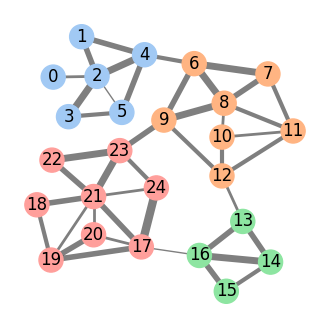

In [8]:
# let's colour the network accordingly
fig, ax = plt.subplots(1, 1, figsize = (4, 4))

nodelist     = []
node_colours = []
for m, colour in zip(M, sns.color_palette()):
    for u in m:
        nodelist.append(u)
        node_colours.append(colour)

nx.draw_networkx_nodes(G = G, pos = pos, ax = ax, nodelist = nodelist, node_color = node_colours)
nx.draw_networkx_edges(G = G, pos = pos, ax = ax, edgelist = sorted(G.edges), width = [G.get_edge_data(*e)["weight"] for e in sorted(G.edges)], alpha = 0.5)
nx.draw_networkx_labels(G = G, pos = pos, ax = ax)

ax.axis("off")
plt.show()

For a two-level partition, we calculate the codelength with the two-level map equation, $L\left(\mathsf{M}\right) = q H\left(Q\right) + \sum_{\mathsf{m} \in \mathsf{M}} p_\mathsf{m} H\left(P_\mathsf{m}\right)$.

To calculate the two-level map equation, we need to know the module entry rates, $p_{\mathsf{m}\curvearrowleft} = \sum_{u \not \in \mathsf{m}, v \in \mathsf{m}} p_u p_{uv}$ with $p_{uv} = \frac{w_{uv}}{\sum_v w_{uv}}$.

In [9]:
# first, we compute the transition rates because we will use them
transition_rates = dict()

for u in G.nodes:
    for v in G.neighbors(u):
        transition_rates[(u,v)] = G.get_edge_data(u, v)["weight"] / node_strengths[u]

transition_rates

{(0, 2): 1.0,
 (1, 2): 0.5,
 (1, 4): 0.5,
 (2, 0): 0.11764705882352941,
 (2, 1): 0.23529411764705882,
 (2, 3): 0.29411764705882354,
 (2, 4): 0.29411764705882354,
 (2, 5): 0.058823529411764705,
 (3, 2): 0.625,
 (3, 5): 0.375,
 (4, 1): 0.25,
 (4, 2): 0.3125,
 (4, 5): 0.25,
 (4, 6): 0.1875,
 (5, 2): 0.125,
 (5, 4): 0.5,
 (5, 3): 0.375,
 (6, 4): 0.17647058823529413,
 (6, 7): 0.29411764705882354,
 (6, 8): 0.29411764705882354,
 (6, 9): 0.23529411764705882,
 (7, 6): 0.4166666666666667,
 (7, 8): 0.3333333333333333,
 (7, 11): 0.25,
 (8, 7): 0.21052631578947367,
 (8, 6): 0.2631578947368421,
 (8, 9): 0.2631578947368421,
 (8, 10): 0.10526315789473684,
 (8, 11): 0.15789473684210525,
 (9, 8): 0.3125,
 (9, 6): 0.25,
 (9, 12): 0.1875,
 (9, 23): 0.25,
 (10, 8): 0.2857142857142857,
 (10, 11): 0.2857142857142857,
 (10, 12): 0.42857142857142855,
 (11, 7): 0.2727272727272727,
 (11, 10): 0.18181818181818182,
 (11, 8): 0.2727272727272727,
 (11, 12): 0.2727272727272727,
 (12, 10): 0.2727272727272727,
 (12, 9)

In [10]:
# to calculate the two-level map equation, we need to know the module entry rates
entry_rates = []

# we get them by looking up, for each module, how many links 
for m in M:
    m_entry = 0
    for v in m:
        for u in G.neighbors(v):
            if u not in m:
                m_entry += p[u] * transition_rates[u,v]
    entry_rates.append(m_entry)

entry_rates

[0.01, 0.03, 0.01, 0.016666666666666666]

In [11]:
# then, we're ready to calculate the codelength
codelength = 0

# first, the codelength for the index-level codebook.
Q = entry_rates
q = sum(Q)
codelength += q * entropy(Q, base = 2)

# then, we add the codelength for each module
for m, m_exit in zip(M, entry_rates):
    P_m = [p[u] for u in m] + [m_exit]
    p_m = sum(P_m)
    codelength += p_m * entropy(P_m, base = 2)

print(f"L(M) = {codelength:.4f} bits")

L(M) = 3.0864 bits


We confirm our result with Infomap.

In [12]:
# we can use Infomap to compute the codelength for the one-level partition by using the no_infomap flag.

# create an Infomap instance
im = infomap.Infomap(silent = True, no_infomap = True)

# add the network
im.add_networkx_graph(G)

# run it
im.run()

print(f"L(M_1) = {im.codelength:.4f} bits")

L(M_1) = 4.5254 bits


In [13]:
# or we can use Infomap to detect communities

# create an Infomap instance
im = infomap.Infomap(silent = True)

# add the network and get Infomap's internal names for the nodes
im.add_networkx_graph(G)

# run it
im.run()

# collect Infomap's modules
modules = dict()
for u,m in dict(im.modules).items():
    if m not in modules:
        modules[m] = set()
    modules[m].add(u)

print(f"Infomap detected modules: {[sorted(m) for m in modules.values()]}")
print(f"L(M) = {im.codelength:.4f} bits")

Infomap detected modules: [[0, 1, 2, 3, 4, 5], [6, 7, 8, 9, 10, 11, 12], [13, 14, 15, 16], [17, 18, 19, 20, 21, 22, 23, 24]]
L(M) = 3.0864 bits
